#**CST338 Project II: Predicting Arrival Delay for Domestic Flights in the US**
---

>Authors: Esha Sawant, Siddhi Ghorpade, Vighnesh Prabhu


> Date: December 4, 2021.





#**Introduction**











From having to go through airport security to lost baggage, the most common air travel inconveniences are flight delays and cancellations. Accurate estimation of flight delay is critical for both airlines and passengers and can be advantageous in improving flyer experience as well as profits. 
A 15 minute delay past scheduled arrival time means that the flight is considered delayed by the Federal Aviation Administration (FAA). 

> This project proposes two models for predicting-
*   Whether a domestic flight will be delayed or not
*   Domestic flight delays during holiday season (the month of December)

> The dataset that we will use for this project was downloaded from Kaggle on December 4, 2021 - https://www.kaggle.com/giovamata/airlinedelaycauses

It contains records of delayed, cancelled, diverted and on-time domestic flights operated by large carriers for the year 2008 collected by the U.S. Department of Transportation's (DOT) Bureau of Transportation Statistics (BTS). This dataset is a subset of a dataset from the Statistical Computing Statistical Graphics 2009 Data Expo which contains records from 1987 to 2008. It was compiled by owner Giovanni Gonzalez in 2016 and made available to the public on Kaggle. It was last updated in 2019.

The dataset has approximately 2 million records of domestic flights providing the scheduled and delayed times, reasons for delay, carrier name, destination and source airports, and much more. All information essential for predicting delay.  

#**Reading the data**

In [ ]:
#Importing all the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns        
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier, export_graphviz, plot_tree
from sklearn.model_selection import learning_curve, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import cross_val_score
from sklearn import tree
import graphviz 

#graphics5
rcParams['figure.figsize']=10,6
sns.set_context('notebook')

In [ ]:
# Mounting Google Drive on runtime's virtual machine
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
# Reading the dataset and storing it in a dataframe
data_dir='/content/drive/MyDrive/DelayedFlights.csv'
df = pd.read_csv(data_dir,low_memory=False)

In [ ]:
#df=df.sample(n=200000)

#**Initial** **Exploration**

> We will start off by getting a quick overview of the data. 
The df.info() method will help us get a quick look at the number of rows and columns, dtypes and non_null values.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1936758 entries, 0 to 1936757
Data columns (total 30 columns):
 #   Column             Dtype  
---  ------             -----  
 0   Unnamed: 0         int64  
 1   Year               int64  
 2   Month              int64  
 3   DayofMonth         int64  
 4   DayOfWeek          int64  
 5   DepTime            float64
 6   CRSDepTime         int64  
 7   ArrTime            float64
 8   CRSArrTime         int64  
 9   UniqueCarrier      object 
 10  FlightNum          int64  
 11  TailNum            object 
 12  ActualElapsedTime  float64
 13  CRSElapsedTime     float64
 14  AirTime            float64
 15  ArrDelay           float64
 16  DepDelay           float64
 17  Origin             object 
 18  Dest               object 
 19  Distance           int64  
 20  TaxiIn             float64
 21  TaxiOut            float64
 22  Cancelled          int64  
 23  CancellationCode   object 
 24  Diverted           int64  
 25  CarrierDelay      


As we can see from the output, the dataset has 1936758 records of domestic flights and 43 columns. Majority of the columns contain numeric data with only 5 columns containing non-numeric values. The result however doesn't give us much idea about what information each column stores. 



The column 'Unnamed: 0' doesn't seem to store any useful information. It would be helpful to drop it at this stage itself.

In [ ]:
df.drop('Unnamed: 0',axis=1, inplace=True)

**Here is a data dictionary for the harder to interpret columns in the dataset -**


---



> **DepTime** - actual departure time 

> **CRSDepTime** - scheduled departure time 

> **ArrTime** - actual arrival time 

> **CRSArrTime** - scheduled arrival time 

> **UniqueCarrier** - carrier ID  

> **ActualElapsedTime** - actual elapsed time of the flight, in minutes

> **CRSElapsedTime** - 
scheduled elapsed time of the flight, in minutes

> **AirTime** -
airborne time for the flight, in minutes

> **ArrDelay** arrival delay, in minutes

> **Distance** distance between airports, in miles

> **DepDelay** - 
departure delay, in minutes

> **WeatherDelay** - 
delay, in minutes, attributable to weather factors

> **CarrierDelay** - 
delay, in minutes, attributable to the carrier

> **NASDelay** - delay, in minutes, attributable to the National Aviation System

> **SecurityDelay** - 
delay, in minutes, attributable to security factors

>**LateAircraftDelay** - 
delay, in minutes, attributable to late-arriving aircraft

---

To have look at the number of unique values in each column, we use the nunique() function.

In [ ]:
df.nunique()

Year                    1
Month                  12
DayofMonth             31
DayOfWeek               7
DepTime              1438
CRSDepTime           1207
ArrTime              1440
CRSArrTime           1364
UniqueCarrier          20
FlightNum            7499
TailNum              5366
ActualElapsedTime     673
CRSElapsedTime        515
AirTime               650
ArrDelay             1128
DepDelay             1058
Origin                303
Dest                  304
Distance             1419
TaxiIn                180
TaxiOut               332
Cancelled               2
CancellationCode        4
Diverted                2
CarrierDelay          983
WeatherDelay          599
NASDelay              574
SecurityDelay         156
LateAircraftDelay     564
dtype: int64

**What kind of variables are we dealing with?**

> A lot of the numeric features in the dataframe store time related information. Therefore, they are cyclical and will have to be encoded before use.

> 'Cancelled' and 'Diverted' are numeric and have no NA values but have only two unique values. It can be said that these are encoded categorical variables.

> 'Origin', 'Dest' and 'UniqueCarrier' all contain string values but have few unique values. These columns store information about the air carrier and airports so it is safe to say that these are encoded as well.



It can also be observed that about half of the columns have NA values. 
We will make use of the isna() function to compute the percentage of NA values in our dataset.

In [ ]:
print('Percentage of NA values = {:.4f}%'.format(df.isna().mean().mean()*100))

Percentage of NA values = 6.2073%


Approximately 6% of the values in the dataset are NA. We use isna() once again to understand which columns have the bigger fraction of NA values.

In [ ]:
df.isna().mean().sort_values(ascending=False)[:15].round(4)

LateAircraftDelay    0.3559
SecurityDelay        0.3559
NASDelay             0.3559
WeatherDelay         0.3559
CarrierDelay         0.3559
ActualElapsedTime    0.0043
AirTime              0.0043
ArrDelay             0.0043
ArrTime              0.0037
TaxiIn               0.0037
TaxiOut              0.0002
CRSElapsedTime       0.0001
TailNum              0.0000
DepDelay             0.0000
Cancelled            0.0000
dtype: float64

The columns containing delay minutes attributed to specific causes contain a lot of NA values. This might be because air carriers do not investigate the delay caused by specific causes enough and tend to focus on the overall delay caused. There are a few other columns with less than 1% of the data being NA.



**What about bad data in the dataset?**

We look at boxplots of the features we think might be good predictors for target 'ArrDelay' to understand how many outliers we are dealing with.

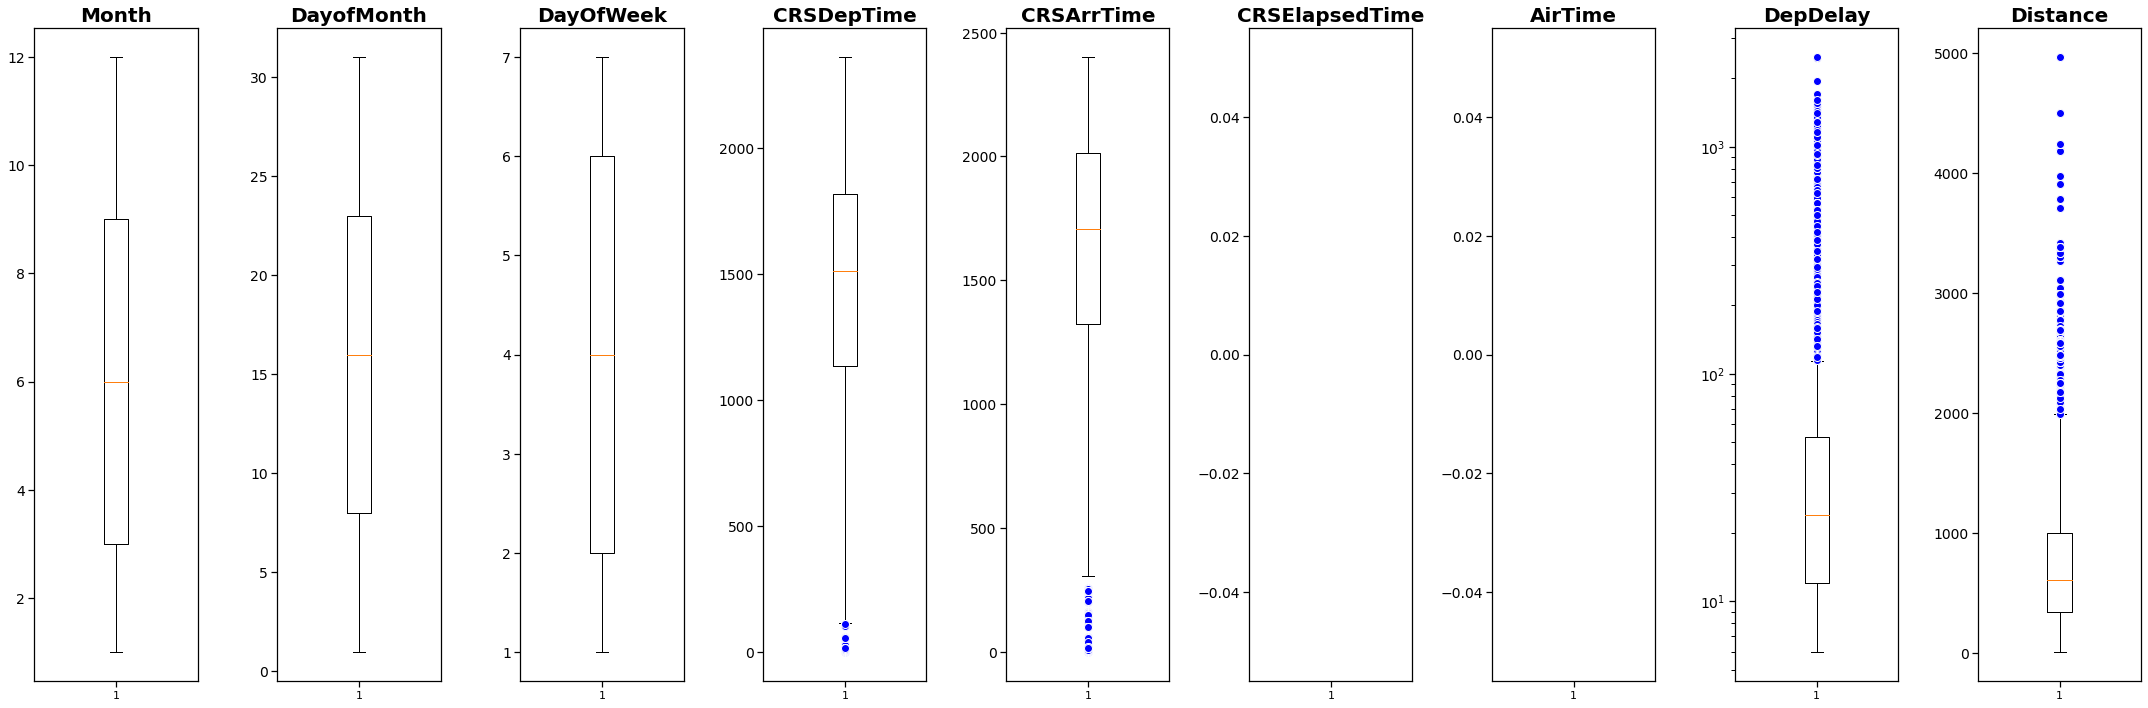

In [ ]:
dfc=df[['Month', 'DayofMonth', 'DayOfWeek', 'CRSDepTime', 'CRSArrTime','CRSElapsedTime', 'AirTime','DepDelay', 'Distance']]
fig, axs = plt.subplots(1, len(dfc.columns), figsize=(30,10))

for i, ax in enumerate(axs.flat):
    ax.boxplot(dfc.iloc[:,i],flierprops = dict(marker='o', markerfacecolor='b', markersize=8, markeredgecolor='w'))
    ax.set_title(dfc.columns[i], fontsize=20, fontweight='bold')
    ax.tick_params(axis='y', labelsize=14)
    #Applying logarithmic scaling to DepDelay
    if dfc.columns[i] == 'DepDelay':
        ax.semilogy()
plt.tight_layout()


As can be observed from the plots, we are dealing with quite a few outliers in the 'DepDelay' and 'Distance' columns.
The outliers in the 'Distance' column are a natural part of the population that we studying; most domestic flights cover distances between 0-2000 miles but there are a still flights that cover distnaces greater than that. So the outliers are not bad data. The same can be said about 'DepDelay'. On some occasions flights can be delayed for more than a couple of hours.

The boxplots for some of the features did not render here. Let's try plotting them individually and begin preprocessing of our dataset.

#**Data Cleaning and Preprocessing**

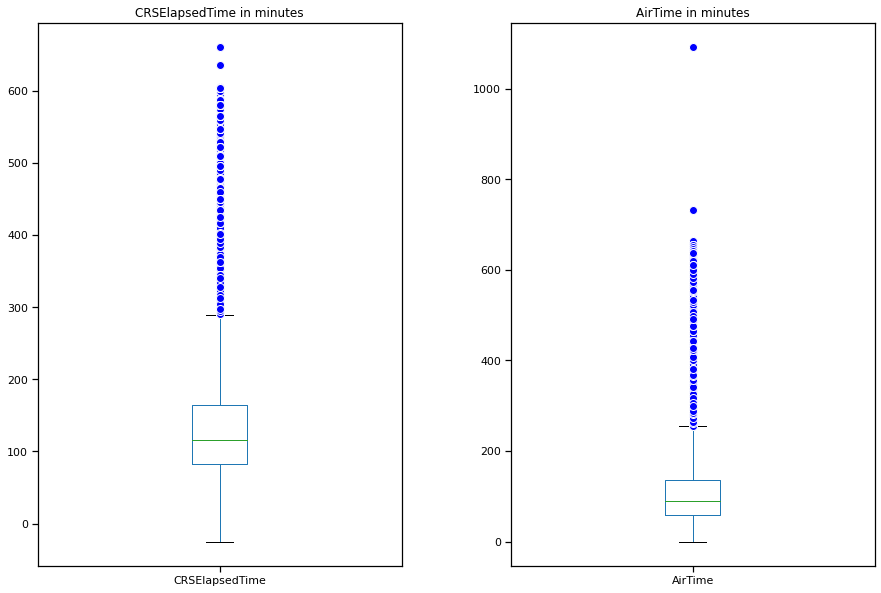

In [ ]:
fig = plt.figure(figsize=(15, 10))
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=None)
plt.subplot(1,2,1);
df['CRSElapsedTime'].plot.box(flierprops = dict(marker='o', markerfacecolor='b', markersize=8, markeredgecolor='w'));
plt.title('CRSElapsedTime in minutes');
plt.subplot(1,2,2);
df['AirTime'].plot.box(flierprops = dict(marker='o', markerfacecolor='b', markersize=8, markeredgecolor='w'));
plt.title('AirTime in minutes');

The outliers in 'AirTime' can also be said to have been caused by longer than usual flights. So it's not all bad data either.

> The columns we are interested don't seem to have a lot of bad data, they just seem to be spread out.



Let's visualize the features to familiarize ourselves more with our predictors. 

In [ ]:
(df['CRSElapsedTime']>300).sum()

76443

In [ ]:
(df['ActualElapsedTime']>300).sum()

74623

In [ ]:
(df['AirTime']>300).sum()

42523

In [ ]:
#where do most delayed flights originate from
df['Origin'].value_counts()[:10].plot.bar()

In [ ]:
#the number of delays caused by each carrier
df['UniqueCarrier'].value_counts(normalize=True).plot.barh();

In [ ]:
df['DayOfWeek'].value_counts().sort_index().plot.bar();
#sns.histplot(df['DayOfWeek'])

In [ ]:
dfs=df[df['DayOfWeek']==5]
dfs['Origin'].value_counts()[:10].plot.bar();

In [ ]:
df['Month'].value_counts(normalize=True).sort_index().plot.bar()
#sns.kdeplot(df['Month'])

In [ ]:
#dfs=df[df['Month']==12]
#dfs['DayofMonth'].value_counts()[:10].plot.bar()  #do kde
plt.hist(df['CRSDepTime'],bins=20)

In [ ]:
sns.histplot(x=df['ArrDelay'])

ENCODING CYCLICAL VARIABLES

In [ ]:
df['CRSDepTime_sin'] = np.sin(df['CRSDepTime']*(2.*np.pi/24))
df['CRSDepTime_cos'] = np.cos(df['CRSDepTime']*(2.*np.pi/24))
df['CRSArrTime_sin'] = np.sin(df['CRSArrTime']*(2.*np.pi/24))
df['CRSArrTime_cos'] = np.cos(df['CRSArrTime']*(2.*np.pi/24))
df['DayofMonth_sin'] = np.sin((df['DayofMonth']-1)*(2.*np.pi/12))
df['DayofMonth_cos'] = np.cos((df['DayofMonth']-1)*(2.*np.pi/12))
df['DayOfWeek_sin'] = np.sin((df['DayOfWeek']-1)*(2.*np.pi/7))
df['DayOfWeek_cos'] = np.cos((df['DayOfWeek']-1)*(2.*np.pi/7))

In [ ]:
df.drop(df[['Year','TailNum','FlightNum','ActualElapsedTime','CRSElapsedTime','TaxiIn','TaxiOut','CancellationCode','Cancelled','Diverted','CarrierDelay','WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay']],axis=1,inplace=True)

In [ ]:
df.info()

In [ ]:
df.isna().mean().mean()

In [ ]:
df.nunique().sort_values(ascending=False)

In [ ]:
#replacing nan values with 0.0
delay={'CarrierDelay':0.0,'WeatherDelay':0.0,'NASDelay':0.0,'SecurityDelay':0.0,'LateAircraftDelay':0.0}
df.fillna(delay,inplace=True)

In [ ]:
#Decoding the carrier names
carrier={'9E':'Pinnacle','AA':'American','AS':'Alaska','B6':'JetBlue','CO':'Continental','DL':'Delta Air','EV':'Atlantic Southeast','F9':'Frontier','FL':'AirTran','MQ':'American Eagle','NW':'Northwest','OH':'Comair','OO':'SkyWest','RU':'ExpressJet','UA':'United Airlines','US':'US Airways','WN':'Southwest','XE':'ExpressJet','YV':'Mesa'}
df['UniqueCarrier'].replace(carrier,inplace=True)

In [ ]:
df.drop(df.index[df['ArrDelay'].isnull()],inplace=True)

#**Visualization**

In [ ]:
dfs=df[df['ArrDelay']>180]
dfs['UniqueCarrier'].value_counts().plot.bar()

###**ML**

In [ ]:
arrMode=df['ArrDelay'].mode()[0]
def funcy(s):
  if(s>=arrMode):
    return 1
  else:
    return 0

In [ ]:
  df['Delay']= df['ArrDelay'].apply(funcy)
  df['Delay'].value_counts()

In [ ]:
df.isnull().sum()

In [ ]:
dfc = df[df['ArrDelay']<300]
dfc=dfc[dfc['Month']==12]

In [ ]:
target='Delay'
predictors=list(dfc.columns)
predictors.remove(target)
rem=['UniqueCarrier','Dest','Origin']#,'DayofMonth','DayOfWeek','ArrDelay','DepDelay']
for x in rem:
  predictors.remove(x)

X=dfc[predictors]
y=dfc[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [ ]:
#Sanity Check
print(X_train.shape)
print(y_train.shape)

In [ ]:
#blind_prediction = pd.Series(y_train)
baseline_accuracy = (y_train == 1).mean()
print('Baseline Accuracy: {:.3f}'.format(baseline_accuracy))

In [ ]:
grid=[{'n_neighbors':range(3,15),'weights':['uniform','distance'],'p':[1,2]}]
knnCV= GridSearchCV(KNeighborsClassifier(),grid,cv=10,scoring='accuracy')

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.45, random_state=0)

In [ ]:
knnCV.fit(X_train,y_train)

In [ ]:
#Forward Feature Selection
def forward_selection_classif(knnCV, X, y, threshold=None, num_folds=5):      
    remaining = list(range(X.shape[1]))
    selected = []
    accuracies = []
    previous_best = 0.0
    while len(remaining) > 0:
        
        best_i, best_accuracy = 0, 0.0
        for i in remaining:
            accuracy = cross_val_score(knnCV, X[:,selected+[i]], y, cv=num_folds).mean()
            if accuracy > best_accuracy:
                best_i, best_accuracy = i, accuracy
                
        if (threshold is not None) and (best_accuracy - previous_best) < threshold:
             break
        selected.append(best_i)
        accuracies.append(best_accuracy)
        remaining.remove(best_i)
        previous_best = best_accuracy
    return np.array(selected), accuracies

In [ ]:
def plot_selected(selected, accuracies, predictors):
    pd.Series(accuracies, index=predictors[selected]).plot.barh()
    plt.xlim(0.5, 1.0)
    plt.xlabel('Cross-validation accuracy')
    plt.title('Result of forward feature selection')

In [ ]:
selected, accuracies = forward_selection_classif(knnCV.best_estimator_, X_train, y_train, num_folds=10)
plot_selected(selected[:10], accuracies[:10], np.array(predictors))

In [ ]:
y_pred=knnCV.predict(X_test)

In [ ]:
#training accuracy
knnCV.best_score_

In [ ]:
#test accuracy
knnCV.best_estimator_.score(X_test,y_test)

In [ ]:
pd.crosstab(y_pred,y_test,normalize='index').plot.bar(stacked=True)

In [ ]:
train_sizes, train_scores, test_scores = learning_curve(knnCV.best_estimator_, X_train, y_train, cv=10, scoring='accuracy')

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

In [ ]:
plt.plot(train_sizes, train_scores_mean, label='train')
plt.plot(train_sizes, test_scores_mean, label='test')
plt.xlabel('training set size')
plt.ylabel('Accuracy')
plt.title('Learning curve, decision tree')
plt.legend()

In [ ]:
pf=PolynomialFeatures(degree=2,include_bias=False)
pf.fit(X)
X_poly=pf.transform(X)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.4, random_state=0)

In [ ]:
#training accuracy with polynomial features
knnCV.best_estimator_.fit(X_train,y_train)
knnCV.best_score_

In [ ]:
y_pred=knnCV.predict(X_test)

In [ ]:
#test accuracy with polynomial features
(y_pred==y_test).mean()

In [ ]:
pd.crosstab(y_pred,y_test,normalize='index').plot.bar(stacked=True)

In [ ]:
train_sizes, train_scores, test_scores = learning_curve(knnCV.best_estimator_, X_train, y_train, cv=10, scoring='accuracy')

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

In [ ]:
plt.plot(train_sizes, train_scores_mean, label='train')
plt.plot(train_sizes, test_scores_mean, label='test')
plt.xlabel('training set size')
plt.ylabel('Accuracy')
plt.title('Learning curve, decision tree')
plt.legend()